In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
from rollout import CarRacing_rollouts

In [1]:
!python vae_train.py

^C


In [20]:
import gym
import numpy as np

class CustomCarRacing(gym.Env):
    def __init__(self):
        # ここに環境の初期化コードを記述します
        pass

    def reset(self):
        # ここにスタート位置を指定するコードを追加します
        self.car_x = 0  # 車のX座標を指定
        self.car_y = 0  # 車のY座標を指定
        self.car_speed = 0  # 車のスピードを指定
        # ... 他の初期化コード ...
        return observation

    def step(self, action):
        # ここにステップを進めるコードを記述します
        pass

    def render(self, mode='human'):
        # ここに描画コードを記述します
        pass

    def close(self):
        # ここに終了処理を記述します
        pass

# カスタム環境を登録します
gym.envs.register(
    id='CustomCarRacing-v2',
    entry_point='custom_car_racing:CustomCarRacing',
    max_episode_steps=1000,  # 最大ステップ数を指定
)


AttributeError: 'CarRacing' object has no attribute 'track'

In [3]:
class Encoder(nn.Module):
    """ Encoder"""

    def __init__(self, z_dim=32):
        super().__init__()

        self.z_dim = z_dim # 潜在表現の次元数

        # 畳み込み層
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2)

        self.mu = nn.Linear(1024, z_dim) # 平均を表現する線形層
        self.log_var = nn.Linear(1024, z_dim) # 分散の対数値を表現する線形層

    def forward(self, x):
        # x: [batch_size, 3, 64, 64]
        c1 = F.relu(self.conv1(x)) # [batch_size, 3, 64, 64] -> [batch_size, 32, 31, 31]
        c2 = F.relu(self.conv2(c1)) # [batch_size, 32, 31, 31] -> [batch_size, 64, 14, 14]
        c3 = F.relu(self.conv3(c2)) # [batch_size, 64, 14, 14] -> [batch_size, 128, 6, 6]
        c4 = F.relu(self.conv4(c3)) # [batch_size, 128, 6, 6] -> [batch_size, 256, 2, 2]

        d1 = c4.view(-1, 1024) # [batch_size, 256, 2, 2] -> [batch_size, 1024]

        mu = self.mu(d1) # [batch_size, 1024] -> [batch_size, z_dim]
        log_var = self.log_var(d1) # [batch_size, 1024] -> [batch_size, z_dim]
        ep = torch.randn_like(log_var) # [batch_size, z_dim], N(0, 1), 正規分布からサンプリング

        z = mu + ep * torch.exp(log_var / 2) # [batch_size, z_dim], 潜在表現をサンプリング

        return z, mu, log_var


In [4]:
class Decoder(nn.Module):
    """Decoder"""

    def __init__(self, z_dim=32):
        super().__init__()

        self.z_dim = z_dim

        self.linear = nn.Linear(z_dim, 1024) # 潜在表現を線形変換する層

        # 転置畳み込み層
        self.conv1 = nn.ConvTranspose2d(1024, 128, kernel_size=5, stride=2)
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2)
        self.conv3 = nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2)
        self.conv4 = nn.ConvTranspose2d(32, 3, kernel_size=6, stride=2)
    
    def forward(self, x):
        # x: [batch_size, z_dim]
        d1 = self.linear(x) # [batch_size, z_dim] -> [batch_size, 1024]
        d1 = d1.view(-1, 1024, 1, 1) # [batch_size, 1024] -> [batch_size, 1024, 1, 1]

        ct1 = F.relu(self.conv1(d1)) # [batch_size, 1024, 1, 1] -> [batch_size, 128, 5, 5]
        ct2 = F.relu(self.conv2(ct1)) # [batch_size, 128, 5, 5] -> [batch_size, 64, 13, 13]
        ct3 = F.relu(self.conv3(ct2)) # [batch_size, 64, 13, 13] -> [batch_size, 32, 30, 30]
        ct4 = F.sigmoid(self.conv4(ct3)) # [batch_size, 32, 30, 30] -> [batch_size, 3, 64, 64]

        return ct4

In [5]:
class VAE(nn.Module):
    """VAE"""

    def __init__(self, z_dim=32):
        super().__init__()

        self.z_dim = z_dim
        self.encoder = Encoder(z_dim) # エンコーダ
        self.decoder = Decoder(z_dim) # デコーダ

    def forward(self, x):
        # x: [batch_size, 3, 64, 64]
        z, mu, log_var = self.encoder(x) # [batch_size, 3, 64, 64] -> [batch_size, z_dim], [batch_size, z_dim], [batch_size, z_dim]
        y = self.decoder(z) # [batch_size, z_dim] -> [batch_size, 3, 64, 64]

        return y, mu, log_var
    
    def encode(self, x):
        ### 画像を潜在表現に変換する ###
        # x: [batch_size, 3, 64, 64]
        z, mu, log_var = self.encoder(x) # [batch_size, z_dim], [batch_size, z_dim], [batch_size, z_dim]
        return z, mu, log_var
    
    def decode(self, z):
        ### 潜在表現から画像を生成する ###
        # z: [batch_size, z_dim]
        y = self.decoder(z) # [batch_size, 3, 64, 64]
        return y
    
    def r_loss(self, y_true, y_pred):
        ### 再構成誤差(RMSE)を計算する ###
        # y_true: [batch_size, 3, 64, 64]
        # y_pred: [batch_size, 3, 64, 64]
        # rmse = (y_true - y_pred) ** 2 # [batch_size, 3, 64, 64]
        # rmse = torch.sum(rmse, dim=(1, 2, 3)) # [batch_size]
        # rmse = torch.sqrt(torch.mean(rmse)) # 1つの値にスカラー変換
        rmse = nn.MSELoss(reduction='none')(y_true, y_pred).mean(dim=(1, 2, 3))
        rmse = torch.sqrt(rmse)
        rmse = torch.mean(rmse)
        return rmse
        
    def kl_loss(self, mu, log_var, kl_tolerance):
        ### 潜在表現の分布と事前分布のKLダイバージェンスを計算する ###
        # mu: [batch_size, z_dim]
        # log_var: [batch_size, z_dim]
        kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1) # [batch_size]
        kl = torch.max(kl, kl.new([self.z_dim * kl_tolerance])) # [batch_size]
        kl = torch.mean(kl) # 1つの値にスカラー変換
        return kl
    
    def loss(self, y_true, y_pred, mu, log_var, kl_tolerance=0.5):
        ### VAEの損失関数を計算する: r_loss + kl_loss ###
        # y_true: [batch_size, 3, 64, 64]
        # y_pred: [batch_size, 3, 64, 64]
        # mu: [batch_size, z_dim]
        # log_var: [batch_size, z_dim]
        r_loss = self.r_loss(y_true, y_pred) # [batch_size]
        kl_loss = self.kl_loss(mu, log_var, kl_tolerance) # [batch_size]
        loss = r_loss + kl_loss # スカラー値
        return loss, r_loss, kl_loss

In [77]:
y = torch.ones(3, 3, 64, 64)
y_true = torch.ones(3, 3, 64, 64) - 1
nn.MSELoss(reduction='none')(y, y_true).mean(dim=(1, 2, 3))

tensor([1., 1., 1.])

In [8]:
num_epoch = 3 # エポック数
batch_size = 2 # バッチサイズ
lr = 0.0001 # 学習率

seq_len = 300 # シーケンスの長さ
num_rollouts = 10000 # ロールアウト数
z_dim = 32 # 潜在表現の次元数

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # GPUが使えるかどうかの確認

model = VAE().to(device) # モデルをGPUへ
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # オプティマイザ

train_history_r = [] # 学習用の損失関数(batchごとの平均)
train_history_kl = [] # 学習用の損失関数
train_history = [] # 学習用の損失関数
test_history_r = [] # テスト用の損失関数(batchごとの平均)
test_history_kl = [] # テスト用の損失関数
test_history = [] # テスト用の損失関数

env = CarRacing_rollouts() # rolloutの取得用

for epoch in range(num_epoch):
    idx = np.arange(num_rollouts).astype(np.int32) # ロールアウトのインデックス
    train_idx = idx[:int(num_rollouts * 0.7)] # 学習用のロールアウトのインデックス
    test_idx = idx[int(num_rollouts * 0.7):] # テスト用のロールアウトのインデックス
    np.random.shuffle(train_idx) # 学習用のロールアウトのインデックスをシャッフル

    train_loss = 0 # 学習用の損失関数
    train_loss_r = 0 # 学習用の損失関数
    train_loss_kl = 0 # 学習用の損失関数
    test_loss = 0 # テスト用の損失関数
    test_loss_r = 0 # テスト用の損失関数
    test_loss_kl = 0 # テスト用の損失関数

    del idx

    model.train() # 学習モード
    print('Train Epoch: {}'.format(epoch+1))
    for i in range(0, len(train_idx), batch_size):
        if i + batch_size > len(train_idx):
            batch_idx = train_idx[i:]
        else:
            batch_idx = train_idx[i:i+batch_size]
        
        train_data, _, _, _ = env.load_rollouts(batch_idx) # ロールアウトの取得

        train_data = train_data / 255.0 # 値を0~1に正規化, [bar_size, seq_len, 64, 64, 3]
        train_data = train_data.reshape(-1, 3, 64, 64) # [batch_size, seq_len, 3, 64, 64] -> [batch_size * seq_len, 3, 64, 64]
        train_data = torch.tensor(train_data, dtype=torch.float32).to(device) # テンソル化, GPUへ

        optimizer.zero_grad() # 勾配の初期化
        y, mu, log_var = model(train_data) # z: [batch_size, z_dim], mu: [batch_size, z_dim], log_var: [batch_size, z_dim]
        loss, r_loss, kl_loss = model.loss(train_data, y, mu, log_var) # 損失関数の計算, スカラー値
        loss.backward() # 勾配の計算
        optimizer.step() # パラメータの更新

        train_loss += loss.item() # 損失関数の計算
        train_loss_r += r_loss.item() # 損失関数の計算
        train_loss_kl += kl_loss.item() # 損失関数の計算

        if i % 100 == 0:
            print('Epoch: {}, Batch: {}, Loss: {:.3f}, r_loss: {:.3f}, kl_loss: {:.3f}'.format(epoch+1, i, loss.item(), r_loss.item(), kl_loss.item()))

        del train_data
    
    train_history.append(train_loss / len(train_idx))
    train_history_r.append(train_loss_r / len(train_idx))
    train_history_kl.append(train_loss_kl / len(train_idx))

    del train_idx, train_loss, loss, y, mu, log_var, r_loss, kl_loss
    
    model.eval() # 評価モード
    print('Test Epoch: {}'.format(epoch+1))
    for i in range(0, len(test_idx), batch_size):
        if i + batch_size > len(test_idx):
            batch_idx = test_idx[i:]
        else:
            batch_idx = test_idx[i:i+batch_size]
        
        test_data, _, _, _ = env.load_rollouts(batch_idx)
        test_data = test_data / 255.0
        test_data = test_data.reshape(-1, 3, 64, 64)
        test_data = torch.tensor(test_data, dtype=torch.float32).to(device)

        y, mu, log_var = model(test_data)
        loss, r_loss, kl_loss = model.loss(test_data, y, mu, log_var)
        
        test_loss += loss.item()
        test_loss_r += r_loss.item()
        test_loss_kl += kl_loss.item()

        if i % 100 == 0:
            print('Epoch: {}, Batch: {}, Loss: {:.3f}, r_loss: {:.3f}, kl_loss: {:.3f}'.format(epoch+1, i, loss.item(), r_loss.item(), kl_loss.item()))
        
        del test_data

    test_history.append(test_loss / len(test_idx))
    test_history_r.append(test_loss_r / len(test_idx))
    test_history_kl.append(test_loss_kl / len(test_idx))

    del test_idx, test_loss, loss, y, mu, log_var

    # モデルの保存
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, './vae_tolerance4.pth')
    
    # 学習用の損失関数の保存
    np.save('./train_history_torelance4.npy', np.array(train_history))
    np.save('./train_history_r_torelance4.npy', np.array(train_history_r))
    np.save('./train_history_kl_torelance4.npy', np.array(train_history_kl))
    # テスト用の損失関数の保存
    np.save('./test_history_torelance4.npy', np.array(test_history))
    np.save('./test_history_r_torelance4.npy', np.array(test_history_r))
    np.save('./test_history_kl_torelance4.npy', np.array(test_history_kl))

Train Epoch: 1


KeyboardInterrupt: 

In [14]:
vae = VAE().to(device)
checkpoint = torch.load('vae_tolerance3.pth')
vae.load_state_dict(checkpoint['model_state_dict'])
vae.eval()

state, _, _ , _ =  env.load_rollout(0)
state.shape

(300, 64, 64, 3)

In [15]:
import matplotlib.pyplot as plt

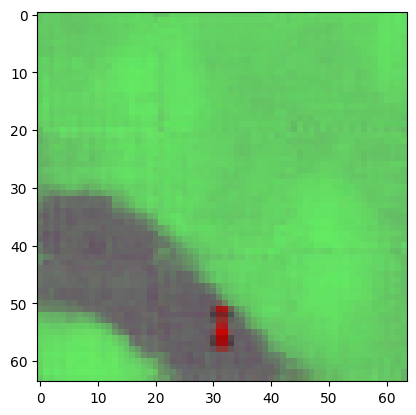

In [16]:
state_sample = state[80]
state_sample = state_sample.reshape(-1, 3, 64, 64)
state_sample = torch.from_numpy(state_sample).float()
state_sample = state_sample.to(device)
state_sample = state_sample / 255.0

state_sample_vae, _, _ = vae(state_sample)
state_sample_vae = state_sample_vae.cpu().detach().numpy()

state_sample_vae = state_sample_vae.reshape(64, 64, 3) * 255.0

plt.imshow(state_sample_vae.astype(np.uint8))

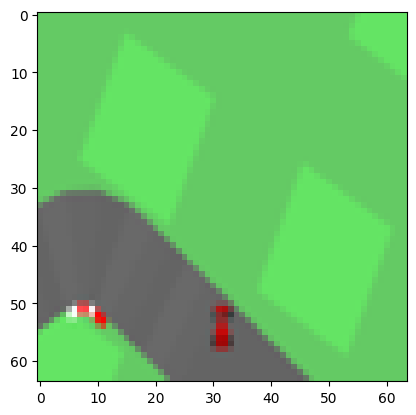

In [18]:
plt.imshow(state[80].astype(np.uint8))

In [17]:
# npyの読み込み
file = "./train_history_torelance.npy"
train_history_torelance = np.load(file)
print(train_history_torelance.shape)

(1,)


In [18]:
train_history_torelance

array([24.1202367])